# EDA - Time Played and Penalty Shootouts

In [1]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.options.mode.chained_assignment = None

In [2]:
# Competitions
COMPS = ['el', 'cl', 'copa_am', 'euro_cup', 'wc']

# Load data from JSON files
data = []
for comp in COMPS:
    with open(f'./data/{comp}.json', 'r') as f:
        data += json.load(f)

In [3]:
# Aggregate data
shots = []
for datum in data:
    shots.extend(datum['shootout'])

In [4]:
# DataFrame of all shots in major tournament penalty shootouts
df = pd.DataFrame(shots)

In [5]:
# Set negative time_played values to 0
df['time_played'] = np.where(df['time_played'] < 0, 0, df['time_played'])

In [6]:
# Engineer make or miss feature
condlist = [(df['result'] == 'Scored'), (df['result'] == 'Missed'), (df['result'] == 'Saved')]
choicelist = [True, False, False]
df['made'] = np.select(condlist, choicelist)

## Summary statistics and initial analysis

In [22]:
df.describe()

,time_played,made
count,2118.000000,2118.000000
mean,100.215297,0.729934
std,36.062324,0.444099
min,0.000000,0.000000
25%,114.750000,0.000000
50%,120.000000,1.000000
75%,120.000000,1.000000
max,120.000000,1.000000


In [7]:
df.groupby('result')['time_played'].describe()

,count,mean,std,min,25%,50%,75%,max
result,,,,,,,,
Missed,289.0,102.183391,35.613340,0.0,120.00,120.0,120.0,120.0
Saved,283.0,97.727915,37.575364,0.0,63.50,120.0,120.0,120.0
Scored,1546.0,100.302717,35.860448,0.0,114.75,120.0,120.0,120.0


In [15]:
df.groupby('made')['time_played'].describe()

,count,mean,std,min,25%,50%,75%,max
made,,,,,,,,
0,572.0,99.979021,36.633025,0.0,116.25,120.0,120.0,120.0
1,1546.0,100.302717,35.860448,0.0,114.75,120.0,120.0,120.0


### Class imbalance and substitute playing time
#### The vast majority of penalty kick takers have played the entire match

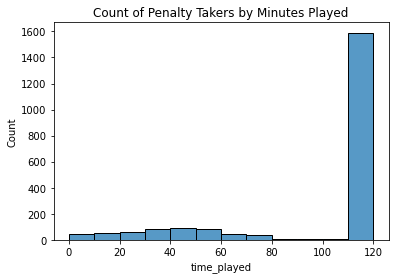

In [16]:
sns.histplot(x='time_played', data=df, bins=12)
plt.title('Count of Penalty Takers by Minutes Played')
plt.show()

#### Most substitutions seem to occur around the 60th minute onward

In [17]:
# Create separate substitutes DataFrame
subs = df.loc[df['time_played'] < 120]
subs['subbed_on'] = 120 - subs['time_played']

In [18]:
subs.describe()

,time_played,made,subbed_on
count,530.000000,530.000000,530.000000
mean,40.935849,0.730189,79.064151
std,22.554023,0.444281,22.554023
min,0.000000,0.000000,7.000000
25%,23.000000,0.000000,63.000000
50%,41.000000,1.000000,79.000000
75%,57.000000,1.000000,97.000000
max,113.000000,1.000000,120.000000


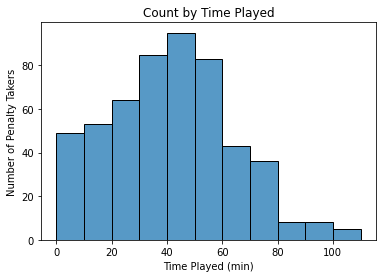

In [19]:
sns.histplot(x='time_played', data=subs, bins=range(0, 120, 10))
plt.title('Count by Time Played')
plt.xlabel('Time Played (min)')
plt.ylabel('Number of Penalty Takers')
plt.show()

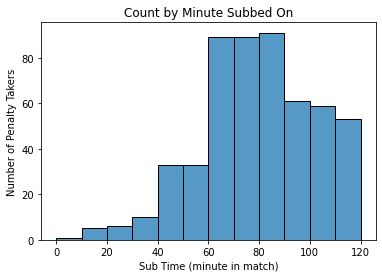

In [20]:
sns.histplot(x='subbed_on', data=subs, bins=range(0, 121, 10))
plt.title('Count by Minute Subbed On')
plt.xlabel('Sub Time (minute in match)')
plt.ylabel('Number of Penalty Takers')
plt.show()

### Evaluating substitutes

In [153]:
# Decile cut of substitution times
subs['q_sub'] = pd.qcut(subs['subbed_on'], q=10)
temp = subs.groupby('q_sub')['made'].mean().reset_index()

In [154]:
def colors_from_values(values, palette_name): # https://stackoverflow.com/a/60917129
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

#### Observation
Players subbed on in the last decile (subbed on in the 109-120th minute) of an added extra time match seem to perform the worst in penalty kick shootouts.

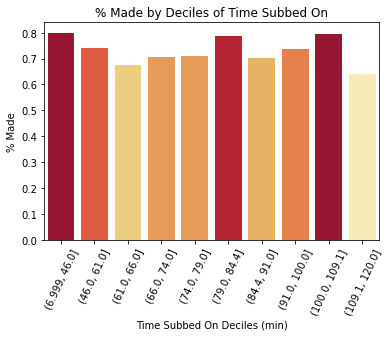

In [156]:
sns.barplot(x='q_sub', y='made', data=temp, palette=colors_from_values(temp['made'], 'YlOrRd'))
plt.xticks(rotation=65)
plt.title('% Made by Deciles of Time Subbed On')
plt.xlabel('Time Subbed On Deciles (min)')
plt.ylabel('% Made')
plt.show()